In [1]:
import bagpipes as pipes
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
import cosmos
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from ReadFilters import *

## Define the essential functions to produce SEDs

In [2]:

def getMags(Wave,Spectrum,N_filters,FilterCurves,FilterLength,FilterType):
	Mags = np.empty(N_filters)
	Mags.fill(0)
	intmode = 0
	cLight = 3.e18
	for filter in range(0,N_filters):
		int_upper = 0.
		int_lower = 0.
		TmpFilter = FilterCurves[filter,:,:]
		TmpFilter = TmpFilter[0:FilterLength[filter],:]
		
		lmin = TmpFilter[0,0]
		lmax = np.max(TmpFilter[:,0])
		l1 = np.where(np.greater(Wave,lmin))[0]
		l2 = np.where(np.less(Wave,lmax))[0]
		if len(l1) != 0 and len(l2) != 0:
	
			if intmode == 0:
		#interpolate filter on a grid of 10,000 points between the minimum and maximum wavelength of the filter
				npoints = 10000
				dl = (lmax-lmin)/npoints
				TmpWave = np.arange(npoints,dtype=float) * dl + lmin
				TmpFilterInterp = np.interp(TmpWave,TmpFilter[:,0],TmpFilter[:,1])
				#interpolate the SED on the same wavelength grid as the filter
				TmpSpectrum = np.interp(TmpWave,Wave,Spectrum)

			if intmode == 1:
		#interpolate filter on the wavelength grid, where the first point of the grid is the first point for which Lambda_SSP > Lambda_Filter_min 
		#and the last point the largest Lambda_SSP for which Lambda_SSP < Lambda_Filter_Max
				TmpWave = Wave[l1[0]:l2[-1]+1] 
				TmpSpectrum = Spectrum[l1[0]:l2[-1]+1]
				TmpFilterInterp = np.interp(TmpWave,TmpFilter[:,0],TmpFilter[:,1])

			if FilterType[filter] == 'ccd':
			#Lower and upper Integral of the magnitude determination function for a photon counting device and an input spctrum in f_lambda in erg/s/cm2/A
				int_upper = np.trapz(TmpFilterInterp*TmpSpectrum*TmpWave,x=TmpWave)
				int_lower = cLight * np.trapz(TmpFilterInterp/TmpWave,x=TmpWave)
			if int_lower != 0 and int_upper != 0:
				Mags[filter] = -2.5 * np.log10(int_upper/int_lower) - 48.6
			else:
				Mags[filter] = 99.
	
		else:
			Mags[filter] = 99.
	return Mags

def Lum2FluxFac(cosmo_pars,redshift,lum_units):
	cosmodata = cosmos.cosmologicaldata(cosmo_pars[0],cosmo_pars[1],cosmo_pars[2],cosmo_pars[3],redshift)
	cosmodata.calculate()
	Dlum_Mpc = cosmodata['DL'] 
	Mpc2cm = 3.08568025 * pow(10,24) # Mpc to cm conversion, assuming DLUM is in Mpc not Mpc/h!
	Dlum_cm = Dlum_Mpc * Mpc2cm
	FluxFac = 1. / ( 4 * np.pi * pow(Dlum_cm,2))
	if lum_units == 'lambda':
		FluxFac = FluxFac / (1. + redshift) 
	elif lum_units == 'nu':
		FluxFac = FluxFac * (1. + redshift)  
	elif lum_units == 'line':
		FluxFac = FluxFac
	return FluxFac

def greeneho2005_lum(mbh,fwhm):
	lum42 = (mbh / (fwhm/1000.)**2.06 / 2e6)**(1/0.55)
	lum = lum42 * 1e42
	return lum

def greeneho2005_mbh(lum,fwhm):
	mbh = 2e6 * (lum/1e42)**0.55 * (fwhm/1000.)**2.06
	return mbh

def greeneho2005_fwhm(mbh,lum):
	fwhm3 = (mbh / (lum/1.e42)**0.55 / 2e6)**(1/2.06)
	fwhm = fwhm3 * 1000.
	return fwhm

def Calzetti_ExCurve(WaveLength):
	Speclen = len(WaveLength)
	ExCurve = np.empty(Speclen)
	rv = 4.05
	c_short = [2.659,-2.156,1.509,-0.198,0.011]
	c_long = [2.659,-1.857,1.04]
	a = np.where(WaveLength >= 6300.)
	WaveLengthMicron = WaveLength / 1.e4
	if len(a[0]) > 0:
		a = a[0][0]
		ExCurve[0:a] = c_short[0] * (c_short[1] + c_short[2]/WaveLengthMicron[0:a] + c_short[3]/pow(WaveLengthMicron[0:a],2) + c_short[4]/pow(WaveLengthMicron[0:a],3)) + rv
		ExCurve[a:Speclen] = c_long[0] * (c_long[1] + c_long[2]/WaveLengthMicron[a:Speclen]) + rv
	else:
		ExCurve[0:Speclen] = c_short[0] * (c_short[1] + c_short[2]/WaveLengthMicron[0:Speclen] + c_short[3]/pow(WaveLengthMicron[0:Speclen],2) + c_short[4]/pow(WaveLengthMicron[0:Speclen],3)) + rv
	return ExCurve

def Calzetti(wave,flux,ebv,direction):
	if ebv > 0:
		curve_calz = Calzetti_ExCurve(wave)

		plotthis = 0
		if plotthis == 1:
			plt.figure(figsize=(6.5, 4))
			plt.plot(wave, curve_calz, '-')
			plt.title('Effective extinction law: Q_e(lambda) (Calzetti et al. 2001)')
			plt.xlabel('Wavelength (A)')
			plt.ylabel('k(lambda)')
			plt.show()
	
		#Now apply extinction correction to input flux vector:
		if direction == 'redden':
			sign = -1.0
		if direction == 'unredden':
			sign = 1.0
		flux_new = flux * (10.**(0.4*sign*ebv*curve_calz)) #Here flux is unreddened by the Milky Way
	
		return flux_new
	else:
		return flux

def gaus_emline(x,b,x0,sigma):
	return b * np.exp(-(x-x0)**2/(2*sigma**2))

def ConvolveSpec(Flux,FWHM):
	Gauss = Gaussian1DKernel(stddev=FWHM)
	Flux_Conv = cnv.convolve(Flux, Gauss, boundary='extend')
	return Flux_Conv

def read_cloudy(file):
	cnt = 0
	with open(file, "r") as f:
		while True:
			line = f.readline()
			cnt += 1
			if len(line) == 0:
				break # end of file
	lines = []
	f =  open(file,"r")
	for i in range(0,cnt):
		line = f.readline()
		lines.append(line)
	f.close()
	return lines

def get_lines_from_cloudy(cloudy_file, cloudy_linelist):
	raw_output = read_cloudy(cloudy_file)
	lines = Table.read(cloudy_linelist, format="csv", comment='#')  
	lines['lam'] = 0.
	lines['lum'] = 0.
	lines['flux'] = 0.
	# parse the cloudy output file and find the line ratios
	for j in range(0,len(lines)):
		id = lines['label'][j]
		id_split = id.split()
		lines['lam'][j] = np.float_(id_split[-1].strip("A"))
		for i in range(0,len(raw_output)):
			str = raw_output[i]
			flds = str.split()
			for k in range(0,len(flds)-4):
				if id_split[0:3] == flds[k:k+3]: 
					lines['lum'][j] = np.float_(flds[k+3])
					lines['flux'][j] = np.float_(flds[k+4])

	# sort on wavelength and scale to Ha = 1
	lines.sort('lam')
	lines['flux'] = lines['flux']/100.
	return lines

def make_line_spectrum(emlines,hascl,ebv_gas,fwhmkms,z,lam_obs):

	lam_rest = lam_obs / (1.+z)
	linespec = lam_rest * 0.0

	for i in range(0,len(emlines)):
		if emlines['lam'][i] > lam_rest[0] and emlines['lam'][i] < lam_rest[-1]:
			wline = emlines['lam'][i]
			fline = emlines['flux'][i]
			fwhm_obs_angstrom = fwhmkms * wline * (1.+z) / 3.e5
			fwhm_rest_angstrom = fwhm_obs_angstrom / (1.+z)
			sigma_rest_angstrom = fwhm_rest_angstrom / 2.355
			hline = fline / np.sqrt(2*np.pi) / sigma_rest_angstrom
			gline = gaus_emline(lam_rest,hline,wline,sigma_rest_angstrom)
			linespec = linespec + gline

	linespec = linespec * hascl
	linespec_red = Calzetti(lam_rest,linespec,ebv_gas,'redden')

	return linespec,linespec_red

## Set up the key modeling parameters

In [65]:
# YOUR PATH
working_path = "/Users/aayushsaxena/Desktop/UCL/JWST-prep/spectrasims/"

# IN PRINCIPLE NO NEED TO CHANGE THIS
cloudy_output_path = working_path + "CLOUDY/"
filter_path = working_path + "FILTER/"
other_filters_path = filter_path
nircam_filters_path = filter_path + "NIRCAM/modAB_mean/nrc_plus_ote/"
miri_filters_path = filter_path + "MIRI/"

# COSMOLOGY
cosmo_pars = [0.3,0.7,0.0,0.7]  # O_M, O_L, O_K, h (these parameters now match those from Carnall et al. 2018 where Bagpipes is described)

# HOST GALAXY
z = 5.72               # source redshift
stellarmass = 5e10    # Msun
veldisp = 300.         # Velocity dispersion: km/s
metallicity = 0.5      # # Z/Z_solar
age = 0.8              # Time since SF switched on: Gyr (needed for: constant and exp sfh)
sfr_stop = 0.0         # Time since SF switched off: Gyr (needed for: constant sfh)
sfh = 'constant'       # alternative: 'exp'
tau = 1.5              # tau (needed for: exp sfh)
host_dust = "Calzetti" # shape of the attenuation curve
host_dust_burst = 2    # extra dust for young stars: multiplies Av
host_EBV = 0.2         # note: AV = RV * E(B-V), with RV = 4.05 for Calzetti

# FILTERS
filt_list = [other_filters_path + 'VLTJ2.res', \
             other_filters_path + 'VLTH2.res', \
             other_filters_path + 'VLTKs2.res', \
             nircam_filters_path + 'F277W_NRC_and_OTE_ModAB_mean.txt', \
             nircam_filters_path + 'F356W_NRC_and_OTE_ModAB_mean.txt', \
             nircam_filters_path + 'F444W_NRC_and_OTE_ModAB_mean.txt'] # desired filters
filt_units = [1,1,1,1e4,1e4,1e4] # conversion factors to convert all filters to Angstroms
filt_shortname = ['J','H','Ks','F277W','F356W','F444W']

# CLOUDY AGN MODEL
cloudy_output_file = 'agn2.out'   # Cloudy model file for the AGN spectrum 
cloudy_linelist = 'agn_lines_wanted.csv'    # list of emission lines to be included in the AGN spectrum
agn_haflux = 1.e-17    # erg/s/cm2 # change to luminosity???      
agn_ebv_gas = 0.2      # mag
agn_fwhmkms = 1000.    # km/s

# BROAD EMISSION LINES
agn_fhahb = 4.5        # broad Ha/Hb flux ratio empirical, observed flux ratio of the broad components; intrinsic=3.1 with AV=1; Nesvadba et al. (2011)
agn_mbh = 5.e8         # Msun
agn_fwhmbroad = 10000. # km/s
agn_scattered_fraction = 0.05  # assumed fraction of the broad line scattered

# WAVELENGTH RANGES
lam_obs_min = 10000.   # Angstrom; minimum observed wavelength of the simulated spectrum
lam_obs_max = 50000.   # Angstrom; maximum observed wavelength of the simulated spectrum


### Derived parameters
# parameters directly derived from the input parameters
logstellarmass = np.log10(stellarmass)
host_Av = host_EBV * 4.05
lam_rest_min = lam_obs_min / (1+z)                # minimum rest wavelength of the simulated spectrum 
lam_rest_max = lam_obs_max / (1+z)                # maximum rest wavelength of the simulated spectrum 
lam_obs = np.arange(lam_obs_min,lam_obs_max,1.)   # observed wavelength axis for the generated spectra, delta_lam = 1A !!!

In [41]:
### FILTERS
# read the filter curves
FilterFile = working_path + 'filters.lst'
f = open(FilterFile,"w")
for k in range(0,len(filt_list)):
	f.write(filt_list[k]+' ccd'+'\n')
f.close()
FilterNames, FilterCurves, FilterType, FilterLen, N_filters, FilterWaves = ReadFilters(FilterFile,filt_units)

Importing Filter Data


## Set up the Bagpipes SED model

Option to turn the nebular emission lines on and off

In [66]:
### SET UP BAGPIPES MODEL

# set up the star formation history
sfh_pars = {} 
sfh_pars["age_max"] = age      
sfh_pars["massformed"] = logstellarmass
sfh_pars["metallicity"] = metallicity          

if sfh == 'constant':                     
	sfh_pars["age_min"] = sfr_stop      
	sfh_pars["massformed"] = logstellarmass
	sfh_pars["metallicity"] = metallicity

if sfh == 'exp':
	sfh_pars.pop("age_max")                      
	sfh_pars["age"] = age                  
	sfh_pars["tau"] = tau                 

# set up the host dust component
dust = {}                         
dust["type"] = host_dust         
dust["Av"] = host_Av                  
dust["eta"] = host_dust_burst      

# set up the model components dictionary for the host galaxy
model_components = {}                   
model_components["redshift"] = z        
model_components[sfh] = sfh_pars
model_components["dust"] = dust
model_components["veldisp"] = veldisp

### nebular emission lines - comment this bit of code to not use nebular lines
nebular = {}                      # Nebular emission component
nebular["logU"] = -2.             # log_10(ionization parameter)


model_components["t_bc"] = 0.01    # Lifetime of birth clouds (Gyr)
model_components["veldisp"] = 300.    # km/s
model_components["nebular"] = nebular

print("Bagpipes parameters loaded, proceed to spectrum creation.")

Bagpipes parameters loaded, proceed to spectrum creation.


In [67]:
# create the host SED spectrum
model = pipes.model_galaxy(model_components, spec_wavs=lam_obs)
host_spectrum = model.spectrum
host_sfh = model.sfh

print("Bagpipes SED created!")

Bagpipes SED created!


## AGN emission from Cloudy

In [68]:

# get the AGN emission lines from Cloudy
emlines = get_lines_from_cloudy(cloudy_output_path + cloudy_output_file, cloudy_output_path + cloudy_linelist)
line_spec, line_spec_dust = make_line_spectrum(emlines,agn_haflux,agn_ebv_gas,agn_fwhmkms,z,lam_obs)

# host + AGN spectrum
spectrum_wlines = host_spectrum[:,1] + line_spec

# host + dust-reddened AGN spectrum
spectrum_wlines_dust = host_spectrum[:,1] + line_spec_dust

# create the broad components of Ha and Hb
lum_broad_Ha = greeneho2005_lum(agn_mbh,agn_fwhmbroad)
flux_broad_ha = lum_broad_Ha * Lum2FluxFac(cosmo_pars, z, "line")
flux_broad_ha_scattered = flux_broad_ha * agn_scattered_fraction
flux_broad_hb_scattered = flux_broad_ha_scattered / agn_fhahb
broadlines = emlines[0:2]
broadlines['label'][0] = 'H  1      6562.81A'
broadlines['lam'][0] = 6562.81
broadlines['flux'][0] = flux_broad_ha_scattered
broadlines['label'][1] = 'H  1      4861.33A'
broadlines['lam'][1] = 4861.33
broadlines['flux'][1] = flux_broad_hb_scattered
broadline_spec, broadline_spec_dust = make_line_spectrum(broadlines,1.0,0.0,agn_fwhmbroad,z,lam_obs)

# host + AGN + broad lines
spectrum_wlines_dust_wbroadlines = spectrum_wlines_dust + broadline_spec

# host + broad lines
spectrum_wbroadlines = host_spectrum[:,1] + broadline_spec

In [69]:
# calculate magnitudes in the filters
sedmags = getMags(lam_obs,spectrum_wlines_dust_wbroadlines,N_filters,FilterCurves,FilterLen,FilterType)
print()
print("Photometry in AB mag:")
for m in range(0,len(sedmags)):
	print(filt_shortname[m], ' ', sedmags[m])
print()


Photometry in AB mag:
J   25.796991116172272
H   25.591979357750965
Ks   25.133231114976432
F277W   24.183929987291968
F356W   23.240886390299742
F444W   23.34071174008482



## Plotting

In [57]:
# OUTPUT PREFERENCES
PlotFilters = 1        # overplot the filter transmission curves
PlotMags = 1           # overplot the calculated magnitudes
second_topaxis = 1     # rest-frame wavelength axis
xfigsize = 12          # width of output figure
yfigsize = 5          # height of output figure

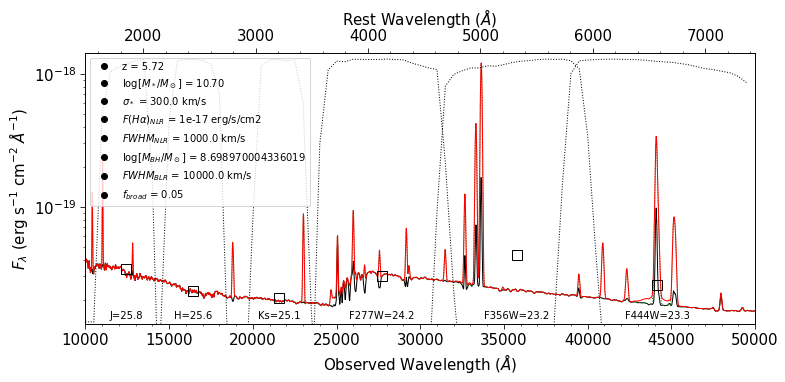

In [70]:
# plot things
fig, ax1 = plt.subplots(figsize=(xfigsize, yfigsize))

# plotting limits
ax1.set_xlim(lam_obs_min,lam_obs_max)
sel = np.logical_and((lam_obs > lam_obs_min),(lam_obs < lam_obs_max))
fmin = np.min(spectrum_wlines_dust[sel])*0.8
fmax = np.max(spectrum_wlines_dust[sel])*1.2
ax1.set_ylim(fmin,fmax)
ax1.set_yscale('log')

# plot the spectra
ax1.plot(host_spectrum[:,0],host_spectrum[:,1],'k',lw=1)
ax1.plot(host_spectrum[:,0],spectrum_wlines_dust,'g:',lw=1)
ax1.plot(host_spectrum[:,0],spectrum_wlines_dust_wbroadlines,'r-',lw=1)

# labels, ticks and secondary axis	
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Observed Wavelength ($\AA$)',fontsize=15)
ax1.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)',fontsize=15)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='minor', length=2, color='k')
ax1.tick_params(which='major', length=5, color='k')
if second_topaxis ==1:
	ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
	ax2.set_xscale('linear')
	ax2.set_xlim([lam_obs_min/(1.+z),lam_obs_max/(1.+z)])
	ax2.set_xlabel('Rest Wavelength ($\AA$)',fontsize=15)  # we already handled the x-label with ax1
	ax2.tick_params(axis='x')
	ax2.tick_params(axis='both', which='major', labelsize=15)
	ax2.xaxis.set_minor_locator(AutoMinorLocator())
	ax2.tick_params(which='minor', length=2, color='k')
	ax2.tick_params(which='major', length=5, color='k')

# overplot filter curves
filtercols = np.repeat('k',len(filt_list))
if PlotFilters == 1:
	for f in range(0,N_filters):
		tmp_l = FilterCurves[f,:,0]
		tmp_f = FilterCurves[f,:,1]
		tmp_l = tmp_l[0:FilterLen[f]]
		tmp_f = tmp_f[0:FilterLen[f]]
		tmp_f = tmp_f / max(tmp_f)
		tmp_f = tmp_f * 0.9 * (fmax-fmin) + 1e-21
#		ax1.plot(tmp_l, tmp_f, ':', linewidth=1, color=filtercols[f])
		lam_new = np.arange(lam_obs_min,lam_obs_max,500)
		ax1.plot(lam_new, np.interp(lam_new,tmp_l,tmp_f), ':', linewidth=1, color=filtercols[f])

# overplot filter magnitudes
fnu_filters = 10.**(-0.4*(sedmags+48.6))
flam_filters = 3.e18 * fnu_filters / FilterWaves**2
if PlotMags == 1:
	ax1.plot(FilterWaves, flam_filters, 'ks', ms=10, markerfacecolor='none')
	for f in range(0,len(sedmags)):
		ax1.text(FilterWaves[f], fmin*1.1, filt_shortname[f]+'='+np.str(sedmags[f]+0.05)[0:4], fontsize=10, ha='center')

# plot information box
p1, = ax1.plot(0,1e-20,'ko',label='z = '+np.str(z))
p2, = ax1.plot(0,1e-20,'ko',label='log[$M_*/M_\odot$] = '+"%.2f" %logstellarmass)
p3, = ax1.plot(0,1e-20,'ko',label='$\sigma_*$ = '+np.str(veldisp)+' km/s')
p4, = ax1.plot(0,1e-20,'ko',label='$F(H\\alpha)_{NLR}$ = '+np.str(agn_haflux)+' erg/s/cm2')
p5, = ax1.plot(0,1e-20,'ko',label='$FWHM_{NLR}}$ = '+np.str(agn_fwhmkms)+' km/s')
p6, = ax1.plot(0,1e-20,'ko',label='log[$M_{BH}/M_\odot$] = '+np.str(np.log10(agn_mbh)))
p7, = ax1.plot(0,1e-20,'ko',label='$FWHM_{BLR}}$ = '+np.str(agn_fwhmbroad)+' km/s')
p8, = ax1.plot(0,1e-20,'ko',label='$f_{broad}$ = '+np.str(agn_scattered_fraction))
plt.legend(loc=2, handles=[p1,p2,p3,p4,p5,p6,p7,p8],fontsize=10)

# plt.savefig(working_path + 'TGSS1530_spectrum.png', facecolor='w', dpi=200)
plt.show()


array([[1.00000000e+04, 1.07163208e-19],
       [1.00010000e+04, 1.07353089e-19],
       [1.00020000e+04, 1.07542970e-19],
       ...,
       [4.99970000e+04, 2.13556121e-20],
       [4.99980000e+04, 2.13546287e-20],
       [4.99990000e+04, 2.13536453e-20]])